# Phantom image reconstruction and registration

Import all packages needed for PET image reconstruction and registration

In [7]:
import numpy as np
import os, sys
import time
import glob
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
from miutil import plot

import scipy.ndimage as ndi
import nibabel as nib
from scipy import ndimage

# > NiftyPET image reconstruction/analysis
from niftypet import nipet
from niftypet import nimpa

# > image registration and resampling
import dipy
from dipy.align import resample
from dipy.align import (affine_registration, center_of_mass, translation,
                        rigid, affine)

# > import tools for ACR parameters, 
# > templates generation and I/O
import acr_params as pars
import acr_tmplates as ast
import acr_ioaux as ioaux

## Imaging initialisation

Download the ACR raw and design data from [the Zenodo repository](https://doi.org/10.5281/zenodo.5760092), and point to the top directory of this dataset as shown below. 

In [11]:
# > core path with ACR phantom inputs
cpth = Path('/sdata/ACR_data_design')

# > get dictionary of constants, Cntd, for ACR phantom imaging
Cntd = pars.get_params(cpth)

# > get all the constants and LUTs for the mMR scanner
mMRpars = nipet.get_mmrparams()

# > standard and exploratory output
outname = 'output_s'

# > update the dictionary of constants with I/O paths
Cntd = ioaux.get_paths(Cntd, mMRpars, cpth, outdir=outname)

# > generate hardware mu-map for the phantom
muhdct = nipet.hdw_mumap(Cntd['datain'], [3,4], mMRpars, outpath=Cntd['opth'], use_stored=True)

## List-mode histogramming

Run the histogramming and show the sum of sinorams as well as the head curve (total counts per second):

Text(0.5, 1.0, 'Summed sinograms')

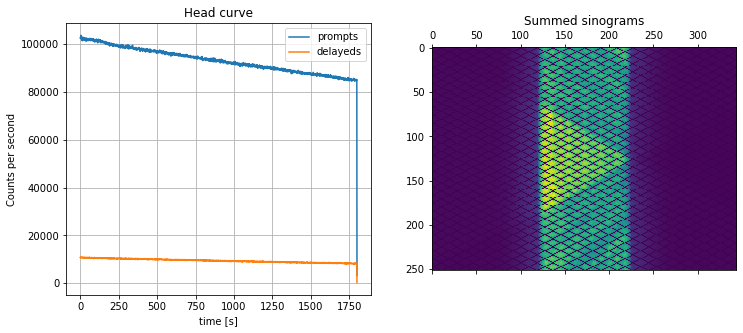

In [28]:
# > histogram the raw PET list-mode data
hst = nipet.mmrhist(Cntd['datain'], mMRpars)

fig, axs = plt.subplots(1,2, figsize=(12, 5))

# > plot the headcurve
axs[0].plot(hst['phc'], label='prompts')
axs[0].plot(hst['dhc'], label='delayeds')
axs[0].grid('on')
axs[0].legend()
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('Counts per second')
axs[0].set_title('Head curve')

# > show the sum of all sinograms
axs[1].matshow(np.sum(hst['psino'], axis=0))
axs[1].set_title('Summed sinograms')


## NAC PET image reconstruction

The non-attenuation corrected (NAC) PET image (the attenuation of the patient bed is accounted for) is reconstructed for the purposes of image registration, so that the an accurate attenuation can be performed using aligned $\mu$-map as well as having accurate and precise sampling of the phantom volumes of interest (VOI).

In [21]:
# > reconstruct the phantom without object attenuation correction
if not 'imupd' in Cntd:
    recon = nipet.mmrchain( 
            Cntd['datain'],
            mMRpars,
            histo=hst,
            mu_h = muhdct, 
            itr=Cntd['itr_nac'],
            fwhm=Cntd['fwhm_nac'],
            recmod=1,
            outpath=Cntd['opth'],
            fout=Cntd['fnac'],
            store_img = True,
            trim=True,
            trim_scale=Cntd['sclt'],
            trim_interp=1,
            trim_store=True,
            )
    nacim = recon['trimmed']['im']
else:
    nacim = nimpa.getnii(Cntd['fnacup'])
    

# > update the dictionary of constants with the recon
Cntd = ioaux.get_paths(Cntd, mMRpars, cpth, outdir=outname)

### Plot the reconstructed NAC image

Text(0.5, 1.0, 'Faceplate insert section')

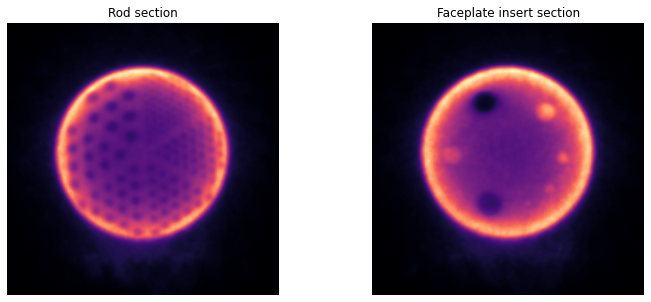

In [25]:
# > plot the NAC PET reconstruction and template
fig, axs = plt.subplots(1,2, figsize=(12, 5))

axs[0].imshow(np.sum(nacim[90:240],axis=0), cmap='magma')
axs[0].set_axis_off()
axs[0].set_title('Rod section')

axs[1].imshow(np.sum(nacim[370:440],axis=0), cmap='magma')
axs[1].set_axis_off()
axs[1].set_title('Faceplate insert section')

## Generate $\mu$-map and NAC PET templates

Run the functions to generate the core $\mu$-map of the ACR phantom together with the NAC PET template facilitating an accurate image registration.  The paths of the generated templates are stored in `Cntd['out']['facrmu']` and `Cntd['out']['facrdmu']` for $\mu$-maps and `Cntd['out']['facrad']` for the NAC PET template.

In [ ]:
# > generate the mu-map and NAC PET templates
ast.create_mumap_core(Cntd, return_raw=True)
ast.create_nac_core(Cntd, return_raw=True)

### Plot the templates

Please note, that the $\mu$-map template is larger by the acrylic material compared to the NAC template which only represents the air or active water. 

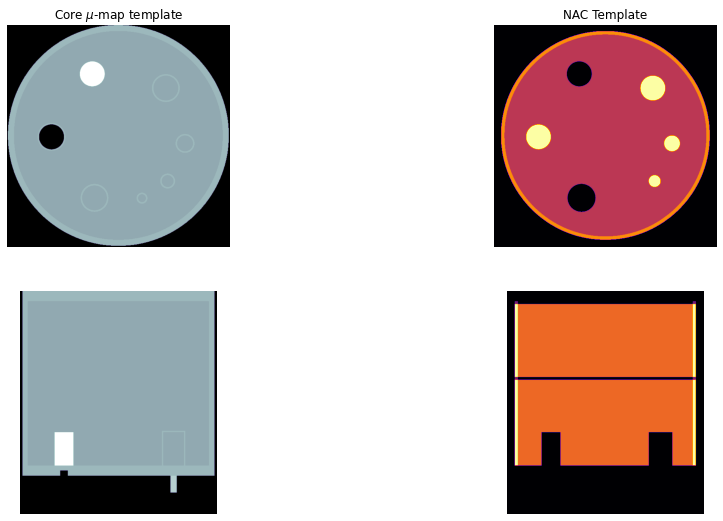

In [33]:
# > get the template images to arrays
tnac = nimpa.getnii(Cntd['out']['facrad'])
tmu  = nimpa.getnii(Cntd['out']['facrdmu'])

# > plot the NAC PET reconstruction and template
fig, axs = plt.subplots(2,2, figsize=(16, 9))
axs[0,0].imshow(tmu[450,...], cmap='bone')
axs[0,0].set_axis_off()
axs[0,0].set_title('Core $\mu$-map template')

axs[0,1].imshow(tnac[450,...], cmap='inferno')
axs[0,1].set_title('NAC Template')
axs[0,1].set_axis_off()

axs[1,0].imshow(tmu[...,230], cmap='bone')
axs[1,0].set_axis_off()

axs[1,1].imshow(tnac[...,230], cmap='inferno')
axs[1,1].set_axis_off()


## Stage I image registration

In this stage I registration the core phantom is alighed in order to perform accurate attenuation correction using aligned $\mu$-map and to perform the analysis in the native PET space.  For more accurate registration, an NAC phantom core template is used and registered to the reference NAC PET image.  In this stage of registration the resolution rods are not yet accounted for.

The registration is performed using Python imaging library [DIPY](https://dipy.org/), using mutual information as the cost function.

Since the registration is performed in high resolution image grid, it will take a longer time, up to one hour, depending on the computing resources.

The aligned $\mu$-map is resampled to the native (original) PET space, before upsampling, and is used for the next quantiative 
image reconstruction.

In [17]:
# > setup the registraiton pipeline
pipeline = [center_of_mass, translation, rigid]

# > registration output folder
dipy_fldr = os.path.dirname(Cntd['out']['faff'])

# > smooth and save the template image for improved registration
fsmo = os.path.basename(Cntd['out']['facrad']).split('.nii')[0]+'_smth'+str(Cntd['fwhm_tmpl']).replace('.','-')+'mm.nii.gz'
fsmo = os.path.join(dipy_fldr, fsmo)
_ = nimpa.imsmooth(Cntd['out']['facrad'], fwhm=Cntd['fwhm_tmpl'], fout=fsmo, dev_id=False)

#===============================================================
if not os.path.isfile(Cntd['out']['faff']):

    # > perform the registration, which can take longer time
    txim, txaff = affine_registration(
        fsmo,
        Cntd['fnacup'],
        nbins=32,
        metric='MI',
        pipeline=pipeline,
        level_iters=Cntd['dipy_itrs'],
        sigmas=Cntd['dipy_sgms'],
        factors=Cntd['dipy_fcts'])

    # > save the registration affine
    np.save(Cntd['out']['faff'], txaff)
    
else:
    txaff = np.load(Cntd['out']['faff'])
#===============================================================

# > smooth the template mu-map
fwhm = 3
fsmo = os.path.basename(Cntd['out']['facrdmu']).split('.nii')[0]+'_smo-'+str(fwhm)+'.nii.gz'
fsmo = os.path.join(dipy_fldr, fsmo)
_ = nimpa.imsmooth(Cntd['out']['facrdmu'], fwhm=fwhm, fout=fsmo, dev_id=False)

# > resample the ACR designed mu-map to the original PET space (2mm voxel size)
# > this mu-map will be used in image reconstruction
new = dipy.align.resample(fsmo, Cntd['fnac'], between_affine=txaff)
nib.save(new, Cntd['out']['fmuo'])

# FOR QUALITY CONTROL:
# > resample the ACR designed mu-map to the upsampled PET space
new = dipy.align.resample(fsmo, Cntd['fnacup'], between_affine=txaff)
nib.save(new, Cntd['out']['fmuo_hires'])

# > resample the NAC templatee to the upsampled PET space
new = dipy.align.resample(Cntd['out']['facrad'], Cntd['fnacup'], between_affine=txaff)
ftnac = os.path.join(dipy_fldr, 'acr-activity-dipy.nii.gz')
nib.save(new, ftnac)

NameError: name 'ftanc' is not defined

### Visualisation of the registration

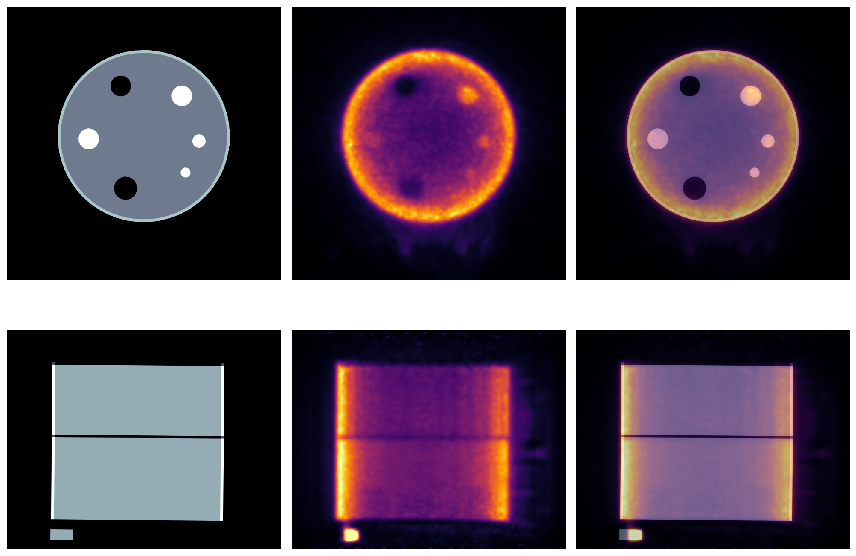

In [20]:
# > get the aligned NAC template
tnac = nimpa.getnii(ftnac)

# > plot the NAC PET reconstruction and template
fig, axs = plt.subplots(2,3, figsize=(12, 9))
axs[0,0].set_axis_off()
axs[0,1].set_axis_off()
axs[0,2].set_axis_off()
axs[1,0].set_axis_off()
axs[1,1].set_axis_off()
axs[1,2].set_axis_off()

#itx = 480
itx = 440
axs[0,0].imshow(tnac[itx,...], 'bone', interpolation='none')
axs[0,1].imshow(nacim[itx,...], 'inferno', interpolation='none')
axs[0,2].imshow(tnac[itx,...], 'bone', interpolation='none')
axs[0,2].imshow(nacim[itx,...], 'inferno', interpolation='none', alpha=0.5)

iax = 320
axs[1,0].imshow(tnac[...,iax], 'bone', interpolation='none')
axs[1,1].imshow(nacim[...,iax], 'inferno', interpolation='none', vmax=0.5*nacim[...,iax].max())
axs[1,2].imshow(tnac[...,iax], 'bone', interpolation='none')
axs[1,2].imshow(nacim[...,iax], 'inferno', interpolation='none', vmax=0.5*nacim[...,iax].max(), alpha=0.5)

plt.tight_layout()

## Quantitative reconstruction for stage II registration

This reconstruction is performed for stage II registration and uses the above generated $\mu$-map for attneuation and scatter corrections.  Note that the $\mu$-map is not fully representative of the real attenuation since the rods are not yet accounted for.  However, since the acrylic rods have slightly higher linear attenuation coefficient, the reconstructed rods will have slightly higher contrast due to the underestimated attenuation (assumed water at this stage).

In [35]:
#-------------------------------------
# > check if reconstruction is needed
if not os.path.isfile(Cntd['fqnt']):

    # > get the mu-map
    mudct = nipet.img.obtain_image(Cntd['out']['fmuo'])
    mudct['im'] = np.float32(mudct['im'])
 
    recon = nipet.mmrchain( 
        Cntd['datain'],
        mMRpars,
        histo=hst,
        mu_h = muhdct, 
        mu_o = mudct,
        itr=Cntd['itr_qnt'],
        fwhm=Cntd['fwhm_qnt'],
        recmod = 3,
        outpath = Cntd['opth'],
        fout=Cntd['fqnt'],
        store_img = True,
    )
#-------------------------------------

# > trim and upsample the QNT image with the same parameters as the NAC image
imup = nimpa.imtrimup(
    Cntd['fqnt'],
    refim=Cntd['fnacup'],
    scale=Cntd['sclt'],
    int_order=1,
    fcomment_pfx=os.path.basename(Cntd['fqnt']).split('.')[0]+'_',
    store_img=True)

# > updated dictionary Cntd with the generated outputs relative to PET
Cntd = ioaux.get_paths(Cntd, mMRpars, cpth, outdir=outname)

-----------------------------------------------------------------
Correcting for trimming outside the original image (z-axis)'
-----------------------------------------------------------------


## Generate the resolution rod template

The generation of the template for the resolution rods is followed by extracting the resolution rod part from the quantiative PET reconstructed above.

In [37]:
# > create the rods' template for the mu-map
ast.create_reso(Cntd, return_raw=False)

# > extract the resolution part from the QNT PET image to perform second 
# > stage of the registration for the resolution rod part
exprf = ioaux.extract_reso_part(Cntd, offset=15)

### Plot the resolution rod tempate and the target PET

In [38]:
resim = nimpa.getnii(Cntd['out']['fpet_res'])
tres = nimpa.getnii(Cntd['out']['fresdQmu'])

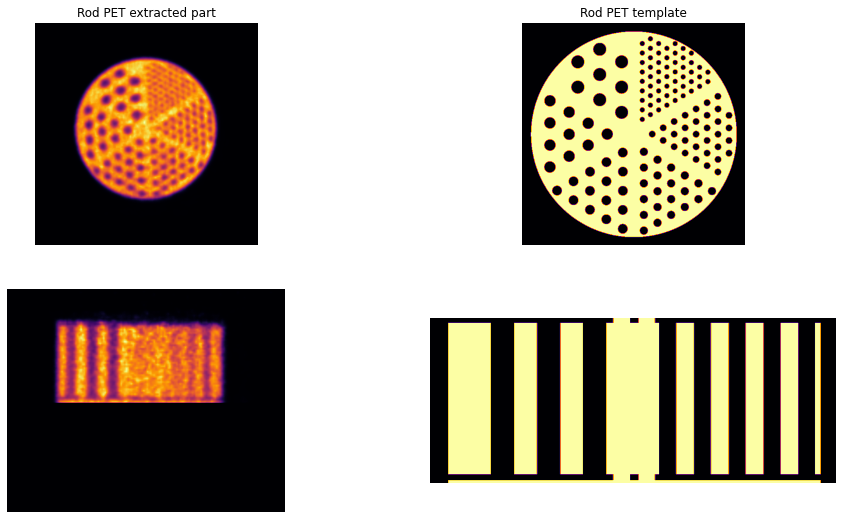

In [76]:
# > plot the QNT PET reconstruction and resolution rod templates
fig, axs = plt.subplots(2,2, figsize=(16, 9))
axs[0,0].imshow(np.sum(resim[90:240,...], axis=0), cmap='inferno')
axs[0,0].set_axis_off()
axs[0,0].set_title('Rod PET extracted part')

axs[0,1].imshow(tres[200,...], cmap='inferno')
axs[0,1].set_title('Rod PET template')
axs[0,1].set_axis_off()

axs[1,0].imshow(np.sum(resim[...,240:260],axis=2), cmap='inferno')
axs[1,0].set_axis_off()

axs[1,1].imshow(tres[...,250], cmap='inferno')
axs[1,1].set_axis_off()


## Stage II image registration

This stage uses the extracted resolution PET part of the phantom and registers to it the resolution rod template, generated above.

In [83]:
# > RESOLUTION RODS REGISTRATION

pipeline = [center_of_mass, translation, rigid]

dipy_fldr = os.path.dirname(Cntd['out']['faff_res'])
fsmo = os.path.basename(Cntd['out']['fresdQmu']).split('.nii')[0]+'_smth'+str(Cntd['fwhm_tmpl']).replace('.','-')+'mm.nii.gz'
fsmo = os.path.join(dipy_fldr, fsmo)
smoim = nimpa.imsmooth(Cntd['out']['fresdQmu'], fwhm=Cntd['fwhm_tmpl'], fout=fsmo, dev_id=False)


#===============================================================
if not os.path.isfile(Cntd['out']['faff_res']):
    txim, txaff = affine_registration(
        fsmo,
        Cntd['out']['fpet_res'],
        nbins=32,
        metric='MI',
        pipeline=pipeline,
        level_iters=Cntd['dipy_rods_itrs'],
        sigmas=Cntd['dipy_sgms'],
        factors=Cntd['dipy_fcts'])

    # > save the affine to Numpy format
    np.save(Cntd['out']['faff_res'], txaff)
    
else:
    txaff = np.load(Cntd['out']['faff_res'])
#===============================================================

# > --- resolution rods mu-map in native PET space ---
fwhm = 3
fsmo = os.path.basename(Cntd['out']['fresdWmu']).split('.nii')[0]+'_smo-'+str(fwhm)+'.nii.gz'
fsmo = os.path.join(dipy_fldr, fsmo)
_ = nimpa.imsmooth(Cntd['out']['fresdWmu'], fwhm=fwhm, fout=fsmo, dev_id=False)

new = dipy.align.resample(fsmo, Cntd['fnac'], between_affine=txaff)
nib.save(new, Cntd['out']['fmur'])
#> ---


# > for quality control
# > rods themselves
new = dipy.align.resample(Cntd['out']['fresdmu'], Cntd['out']['fpet_res'], between_affine=txaff)
frod = os.path.join(dipy_fldr, 'acr-rods-dipy-QC.nii.gz')
nib.save(new, frod)

# > activity among rods
new = dipy.align.resample(Cntd['out']['fresdQmu'], Cntd['out']['fpet_res'], between_affine=txaff)
frodq = os.path.join(dipy_fldr, 'acr-reso-qnt-dipy-QC.nii.gz')
nib.save(new, frodq)

### Visual QC of the registration

First get the images in Numpy arrays

In [ ]:
# > get the quantiative PET image of the rods part
imq = nimpa.getnii(Cntd['out']['fpet_res'])

# > QC: get the array data of aligned template of the rods only
rod = nimpa.getnii(frod)

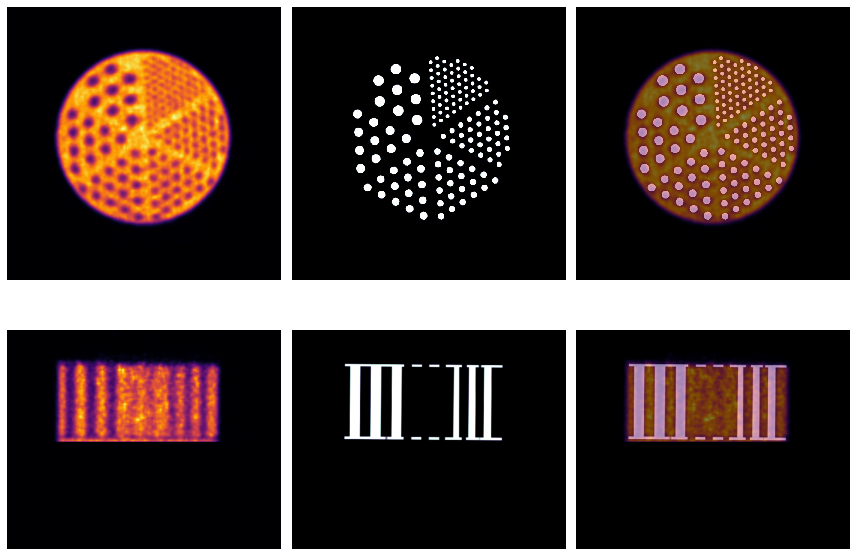

In [123]:
# > plot the NAC PET reconstruction and template
fig, axs = plt.subplots(2,3, figsize=(12, 9))
axs[0,0].set_axis_off()
axs[0,1].set_axis_off()
axs[0,2].set_axis_off()
axs[1,0].set_axis_off()
axs[1,1].set_axis_off()
axs[1,2].set_axis_off()

itx = 150
axs[0,0].imshow(np.sum(imq[100:200,...],axis=0), 'inferno')
axs[0,1].imshow(rod[itx,...], 'bone', interpolation='none')
axs[0,2].imshow(np.sum(imq[100:200,...],axis=0), 'inferno')
axs[0,2].imshow(rod[itx,...], 'bone', interpolation='none', alpha=0.5)

iax = 240
axs[1,0].imshow(np.sum(imq[...,iax:iax+5],axis=2), 'inferno')
axs[1,1].imshow(rod[...,iax+4], 'bone')
axs[1,2].imshow(rod[...,iax+4], 'bone')
axs[1,2].imshow(np.sum(imq[...,iax:iax+10],axis=2), 'inferno', alpha=0.5)

plt.tight_layout()

## Compose the final $\mu$-map

The complete $\mu$-map is composed from the main core $\mu$-map and the resolution rods' $\mu$-map, following the two-stage registration.  It is found as follwos:

In [125]:
#===================================================================
#> complete mu-map by combining the core and resolution rods mu-maps
#===================================================================
acr = nimpa.getnii(Cntd['out']['fmuo'], output='all')
res = nimpa.getnii(Cntd['out']['fmur'])

msk = res>=Cntd['mu_water']-0.0001
acrf = acr['im'].copy()
acrf[msk] = res[msk]

# > ACR full mu-map
acrf = np.float32(acrf)

# > saving the complete mu-map to the path in Cntd['out']['fmuf']
nimpa.array2nii(
    acrf,
    acr['affine'],
    Cntd['out']['fmuf'], 
    trnsp = (acr['transpose'].index(0), acr['transpose'].index(1), acr['transpose'].index(2)),
    flip = acr['flip'])
#===================================================================

### Visualisation of the $\mu$-map alignment

The alignment is shown for the original native PET space of voxel size ~$2$ mm.

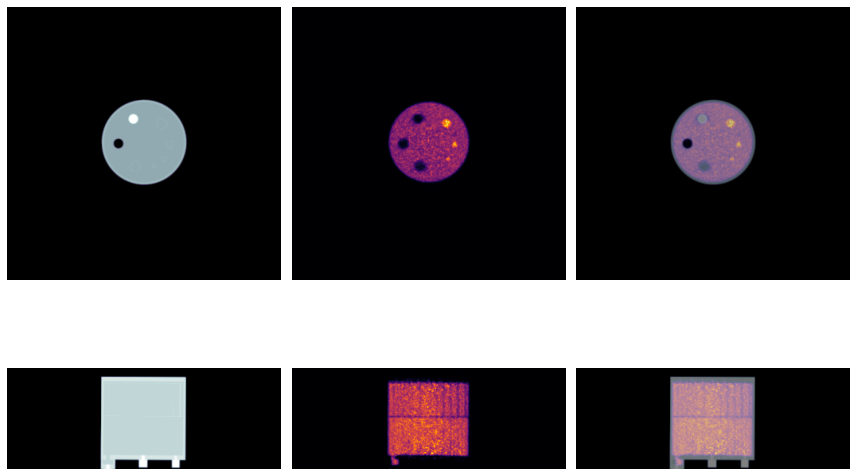

In [129]:
# > get the aligned NAC template
muf = nimpa.getnii(Cntd['out']['fmuf'])
imq = nimpa.getnii(Cntd['fqnt'])

# > plot the NAC PET reconstruction and template
fig, axs = plt.subplots(2,3, figsize=(12, 9))
axs[0,0].set_axis_off()
axs[0,1].set_axis_off()
axs[0,2].set_axis_off()
axs[1,0].set_axis_off()
axs[1,1].set_axis_off()
axs[1,2].set_axis_off()


itx = 100
axs[0,0].imshow(muf[itx,...], 'bone')
axs[0,1].imshow(imq[itx,...], 'inferno')
axs[0,2].imshow(muf[itx,...], 'bone')
axs[0,2].imshow(imq[itx,...], 'inferno', alpha=0.5)

iax = 171
axs[1,0].imshow(muf[...,iax], 'bone')
axs[1,1].imshow(imq[...,iax], 'inferno')
axs[1,2].imshow(muf[...,iax], 'bone')
axs[1,2].imshow(imq[...,iax], 'inferno', alpha=0.5)

plt.tight_layout()

## Reuse of registraion for VOI sampling

The affine matrices of the two rigid body registrations are also used for aligning the sampling templates to the quantiatively reconstructed PET image, and hence making the alignment consistent between attenuation correction and VOI sampling.

The sampling and analysis is shown in the next section.